## Passive Margin

In [22]:
import UWGeodynamics as GEO
import glucifer

In [23]:
u = GEO.UnitRegistry

In [24]:
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-3
GEO.rcParams["nonlinear.tolerance"] =         5e-4
GEO.rcParams["nonlinear.min.iterations"] = 1
GEO.rcParams["CFL"] = 0.1
#GEO.rcParams["CFL"] = 0.5

GEO.rcParams["advection.diffusion.method"] = "SLCN"
GEO.rcParams["shear.heating"] = True
GEO.rcParams["surface.pressure.normalization"] = True  # Make sure the top of the model is approximately 0 Pa

GEO.rcParams["swarm.particles.per.cell.3D"] = 60
GEO.rcParams["popcontrol.split.threshold"] = 0.95
GEO.rcParams["popcontrol.max.splits"] = 100
GEO.rcParams["popcontrol.particles.per.cell.3D"] = 60



In [25]:
##### Characteristic values of the system

half_rate = 1.8 * u.centimeter / u.year # What is it?
model_length = 200e3 * u.meter
model_width = 100e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3395. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2 # ckeck publi schellart

KL = model_length # Characteristic length
Kt = KL / half_rate # Characteristic time
KM = bodyforce * KL**2 * Kt**2 # Characteristic mass
KT = (baseModelTemp - surfaceTemp) # Characteristic temperature

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT


In [26]:
resolution = (32, 16, 16)

In [27]:
Model = GEO.Model(elementRes=resolution, 
                  minCoord=(0. * u.kilometer, 0. * u.kilometer, -110. * u.kilometer),
                  maxCoord=(200. * u.kilometer, 100. * u.kilometer, 18. * u.kilometer),
                  gravity=(0.0 ,0.0, -9.81 * u.meter / u.second**2))

## Global definitions

In [28]:
# ## Output


Model.outputDir="outputs"

Model.diffusivity = 1e-6 * u.metre**2 / u.second
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)



In [29]:
# ## Define Materials


air               = Model.add_material(name="Air", shape=GEO.shapes.Layer3D(top=Model.top, bottom=10.0 * u.kilometer))
stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer3D(top=air.bottom, bottom= 0.0 * u.kilometer))
sedimentMarge     = Model.add_material(name="SedimentMarge", shape=GEO.shapes.Layer3D(top=stickyAir.bottom, bottom= -9.0 * u.kilometer))
uppercrust        = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer3D(top=sedimentMarge.bottom, bottom=-15.0 * u.kilometer))
midcrust          = Model.add_material(name="MidCrust", shape=GEO.shapes.Layer3D(top=-15.0 * u.kilometer, bottom=-20.0 * u.kilometer))
lowercrust        = Model.add_material(name="LowerCrust", shape=GEO.shapes.Layer3D(top=-20.0 * u.kilometer, bottom=-40.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer3D(top=-40.0 * u.kilometer, bottom=-100.0 * u.kilometer))
mantle            = Model.add_material(name="Mantle", shape=GEO.shapes.Layer3D(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment          = Model.add_material(name="Sediment")

wz_slope = GEO.shapes.HalfSpace(normal=(-0.8,0.2,0.5), origin=(158.*u.kilometer,50.*u.kilometer, 0.*u.kilometer))
wz_bottom = GEO.shapes.HalfSpace(normal=(0.8,-0.2,-0.5), origin=(160.*u.kilometer,50.*u.kilometer,0.*u.kilometer))
wz_top = GEO.shapes.HalfSpace(normal=(0.,0.,1.), origin=(200.*u.kilometer,100.*u.kilometer,0.*u.kilometer))
wz_fond = GEO.shapes.HalfSpace(normal=(0.,0.,-1.), origin=(200.*u.kilometer,100.*u.kilometer,-40.*u.kilometer))
compositeShape = wz_slope & wz_top & wz_bottom & wz_fond
Fault = Model.add_material(name="Fault", shape=compositeShape)

# Continent part
top = GEO.shapes.HalfSpace(normal=(0.,0.,1.), origin=(200.*u.kilometer,100.*u.kilometer,0.*u.kilometer))
right = GEO.shapes.HalfSpace(normal=(1.,0.,0.), origin=(200.*u.kilometer,100.*u.kilometer,-0.*u.kilometer))
bottom = GEO.shapes.HalfSpace(normal=(0.,0.,-1.), origin=(200.*u.kilometer,100.*u.kilometer,-40.*u.kilometer))
slope = GEO.shapes.HalfSpace(normal=(-0.8,0.2,0.5), origin=(160.*u.kilometer,50.*u.kilometer,0.*u.kilometer))
CompositeShape_conti = slope & top & right & bottom
continent = Model.add_material(name="continent", shape=CompositeShape_conti)





In [30]:
Fig = glucifer.Figure()
Fig.Surface(Model.mesh, Model.projMaterialField, cullface=False, opacity=1.)
viewer = Fig.viewer(resolution=(1200,600))
viewer.window()

<IPython.core.display.Javascript object>

In [11]:
# ### Material specific definitions
#

air.diffusivity = 1.0e-5 * u.metre**2 / u.second
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
air.density = 0.1 * u.kilogram / u.metre**3 #1.

# In[8]:

# Density

air.density         = 1. * u.kilogram / u.metre**3
stickyAir.density   = 1. * u.kilogram / u.metre**3
Fault.density       = GEO.LinearDensity(reference_density=2000. * u.kilogram / u.metre**3)
sedimentMarge.density = GEO.LinearDensity(reference_density=2400. * u.kilogram / u.metre**3)
uppercrust.density  = GEO.LinearDensity(reference_density=2700. * u.kilogram / u.metre**3)
midcrust.density          = GEO.LinearDensity(reference_density=2850. * u.kilogram / u.metre**3)
continent.density   = GEO.LinearDensity(reference_density=2900. * u.kilogram / u.metre**3)
lowercrust.density  = GEO.LinearDensity(reference_density=2900. * u.kilogram / u.metre**3)
mantleLithosphere.density = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density      = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
sediment.density          = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)

sedimentMarge.radiogenicHeatProd   = 1.2  * u.microwatt / u.meter**3
uppercrust.radiogenicHeatProd = 1. * u.microwatt / u.meter**3
midcrust.radiogenicHeatProd   = 0.7 * u.microwatt / u.meter**3
lowercrust.radiogenicHeatProd = 0.4 * u.microwatt / u.meter**3
continent.radiogenicHeatProd = 1.0 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02 * u.microwatt / u.meter**3
Fault.radiogenicHeatProd = 1.2 * u.microwatt / u.meter**3 # faccenda 2008: 1-5
mantle.radiogenicHeatProd = 0.02 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd   = 0.70 * u.microwatt / u.meter**3


In [12]:
# ### Viscous Rheologies

# In[10]:

rh = GEO.ViscousCreepRegistry()

air.viscosity           = 1e19 * u.pascal * u.second
stickyAir.viscosity     = 1e19 * u.pascal * u.second

sedimentMarge.viscosity = rh.Wet_Quartz_Dislocation_Kronenberg_and_Tullis_1984
sedimentMarge.minViscosity = 1e19 * u.pascal * u.second
sedimentMarge.maxViscosity = 5e23 * u.pascal * u.second

sediment.viscosity = rh.Wet_Quartz_Dislocation_Kronenberg_and_Tullis_1984
sediment.minViscosity = 1e19 * u.pascal * u.second
sediment.maxViscosity = 5e23 * u.pascal * u.second

uppercrust.viscosity    = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
uppercrust.minViscosity = 1e19 * u.pascal * u.second
uppercrust.maxViscosity = 5e23 * u.pascal * u.second

midcrust.viscosity    = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
midcrust.minViscosity = 1e19 * u.pascal * u.second
midcrust.maxViscosity = 5e23 * u.pascal * u.second

lowercrust.viscosity    = rh.Dry_Mafic_Granulite_Dislocation_Wang_et_al_2012

continent.viscosity    = 1.0 * rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
continent.minViscosity = 1e20 * u.pascal * u.second
continent.maxViscosity = 5e23 * u.pascal * u.second

mantleLithosphere.viscosity    = 1.0 * rh.Wet_Dunite_Dislocation_Brace_and_Kohlstedt_1980
mantleLithosphere.minViscosity = 1e19 * u.pascal * u.second
mantleLithosphere.maxViscosity = 1e23 * u.pascal * u.second

mantle.viscosity    = 1.0 * rh.Wet_Dunite_Dislocation_Brace_and_Kohlstedt_1980
mantle.minViscosity = 1e19 * u.pascal * u.second
mantle.maxViscosity = 1e23 * u.pascal * u.second

Fault.viscosity    = 1e19 * u.pascal * u.second # * rh.Goetze_et_al_1978
Fault.minViscosity = 1e18 * u.pascal * u.second
Fault.maxViscosity = 1e20 * u.pascal * u.second

In [13]:

# ## Plasticities

pl = GEO.PlasticityRegistry()

uppercrust.plasticity = GEO.DruckerPrager(
    cohesion=10.*u.megapascal,
    cohesionAfterSoftening=2.*u.megapascal,
    frictionCoefficient=0.55,
    frictionAfterSoftening=0.02,
    epsilon1=0.0, epsilon2=0.2
    )
midcrust.plasticity = GEO.DruckerPrager(
    cohesion=10.*u.megapascal,
    cohesionAfterSoftening=2.*u.megapascal,
    frictionCoefficient=0.55,
    frictionAfterSoftening=0.02,
    epsilon1=0.0, epsilon2=0.2
    )
lowercrust.plasticity = GEO.DruckerPrager(
    cohesion=20.*u.megapascal,
    cohesionAfterSoftening=0.8*u.megapascal,
    frictionCoefficient=0.577,
    frictionAfterSoftening=0.2308,
    epsilon1=0.0, epsilon2=0.2
    )
continent.plasticity = GEO.DruckerPrager(
    cohesion=10.*u.megapascal,
    cohesionAfterSoftening=2.*u.megapascal,
    frictionCoefficient=0.55,
    frictionAfterSoftening=0.02,
    epsilon1=0.0, epsilon2=0.2
    )
mantleLithosphere.plasticity = GEO.DruckerPrager(
    cohesion=10.*u.megapascal,
    cohesionAfterSoftening=0.4*u.megapascal,
    frictionCoefficient=0.577,
    frictionAfterSoftening=0.02,
    epsilon1=0.0, epsilon2=0.2
    )

mantle.plasticity = mantleLithosphere.plasticity

sediment.plasticity = GEO.DruckerPrager(
    cohesion=10.*u.megapascal,
    cohesionAfterSoftening=2.*u.megapascal,
    frictionCoefficient=0.55,
    frictionAfterSoftening=0.02,
    epsilon1=0.0, epsilon2=0.2
    )

Fault.plasticity              = GEO.DruckerPrager(cohesion=2.0 * u.megapascal, frictionCoefficient=0.1154)



Fault.stressLimiter              = 100. * u.megapascal
uppercrust.stressLimiter         = 150. * u.megapascal
midcrust.stressLimiter           = 150. * u.megapascal
lowercrust.stressLimiter         = 150. * u.megapascal
sedimentMarge.stressLimiter      = 150. * u.megapascal
continent.stressLimiter          = 300. * u.megapascal
mantleLithosphere.stressLimiter  = 300. * u.megapascal
mantle.stressLimiter             = 300. * u.megapascal


In [ ]:
Ucrust.minViscosity         = 1e19 * u.pascal * u.second
Ucrust.maxViscosity         = 1e23 * u.pascal * u.second
sediment.minViscosity   = 1e19 * u.pascal * u.second
sediment.maxViscosity   = 1e23 * u.pascal * u.second
Lcrust.minViscosity         = 1e19 * u.pascal * u.second
Lcrust.maxViscosity         = 1e23 * u.pascal * u.second
mantleLithosphere.minViscosity     = 1e19 * u.pascal * u.second
mantleLithosphere.maxViscosity     = 1e23 * u.pascal * u.second
mantle.minViscosity    = 1e19 * u.pascal * u.second
mantle.maxViscosity    = 1e23 * u.pascal * u.second

Ucrust.stressLimiter       = 150 * u.megapascals
Lcrust.stressLimiter       = 150 * u.megapascals
sediment.stressLimiter = 150 * u.megapascals
mantleLithosphere.stressLimiter   = 300 * u.megapascals
mantle.stressLimiter    = 300 * u.megapascals



In [14]:
# # Add Passive Tracers

# In[15]:

import numpy as np

xp = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), 100)
yp = np.linspace(GEO.nd(Model.minCoord[1]), GEO.nd(Model.maxCoord[1]), 100)

xp, yp = np.meshgrid(xp, yp)
xp = xp.flatten()
yp = yp.flatten()
zp = np.zeros(xp.shape)

surface_tracers = Model.add_passive_tracers(name="Surface2", vertices=[xp, yp, zp])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[xp, yp, zp+GEO.nd(mantle.top)])
Lab_tracers = Model.add_passive_tracers(name="Lab", vertices=[xp,yp,-90.*u.kilometer])



In [16]:
# ## Add Temperature Boundary Conditions
#
# Temperature is 293.15K at the top and 3570K at the bottom. Temperature is constant in the mantle and the air layers.

Model.set_temperatureBCs(top=293.15 * u.degK,
                         bottom=1603.15 * u.degK,
                         materials=[(mantle, 1603.15 * u.degK), (stickyAir, 293.15 * u.degK ),
                                    (air, 293.15 * u.degK )])


In [17]:
Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.temperature, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

<IPython.core.display.Javascript object>

In [18]:
Model.init_model()


In [19]:
Model.set_temperatureBCs(top=293.15 * u.degK,
                         bottom=1603.15 * u.degK)


In [20]:
## Add Velocity Boundary Conditions

# The Model was free slip everywhere, which is OK for gravitationally unstable set up but not here...

Model.set_velocityBCs(left=[-2. * u.centimeter / u.year, 0., None],
                      right=[0., 0. , 0.],
                      back=[None, 0., None],
                      front=[None, 0., None],
                      bottom=GEO.LecodeIsostasy(reference_mat=mantle,
                                                average=True))




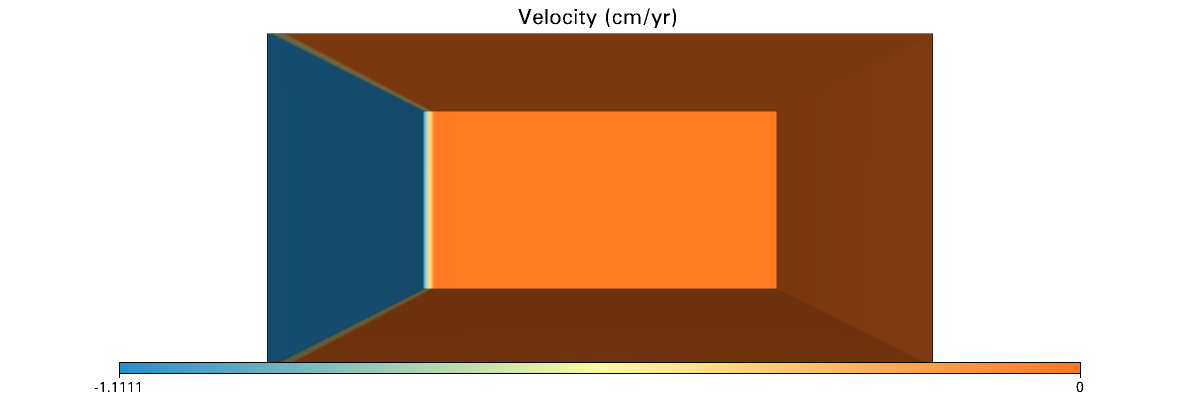

In [21]:
Fig = glucifer.Figure(figsize=(1200,400), title="Velocity (cm/yr)", quality=2)
Fig.Surface(Model.mesh, Model.velocityField[0])
Fig.show()

In [22]:
Fig = glucifer.Figure()
Fig.Points(Model.swarm, Model.pressureField, cullface=False, opacity=1.,)
#Fig.Points(Model.swarm, Model.materialField, cullface=False, opacity=1.)


#Fig.Mesh(Model.mesh)
viewer = Fig.viewer(resolution=(640,480))
viewer = Fig.viewer(axis=True)
viewer = Fig.viewer(rulers=False)
viewer = Fig.viewer(quality=3)


viewer.rotatex(-70)
viewer.rotatey(-10)
viewer.window()

<IPython.core.display.Javascript object>

In [ ]:
# Model.surfaceProcesses = GEO.surfaceProcesses.Badlands(airIndex=[air.index, stickyAir.index], sedimentIndex=sediment.index,
#                                             XML="ressources/badlands.xml", resolution=1.00 * u.kilometer,
#                                             checkpoint_interval=0.005 * u.megayears)                                            checkpoint_interval=0.01 * u.megayears)

## Solver, Model init

In [23]:
solver = Model.solver

# Decide whether to use mumps or multigrid
if resolution[0] * resolution[1] < 1e6:
    print("Using mumps")
    solver.set_inner_method("mumps")
else:
    print("Using multigrid with coarse mumps")
    solver.options.mg.levels = 4
    solver.options.A11.mg_coarse_pc_factor_mat_solver_package = "mumps"
    solver.options.A11.mg_coarse_pc_type = "lu"
    solver.options.A11.mg_coarse_ksp_type = "preonly"

solver.options.A11.ksp_rtol=1e-8
solver.options.A11.ksp_set_min_it_converge = 10
solver.options.A11.use_previous_guess = True
solver.options.scr.ksp_rtol=1e-6
solver.options.scr.use_previous_guess = True
#solver.options.scr.ksp_set_min_it_converge = 10
#solver.options.scr.ksp_type = "cg"

#solver.options.main.help = ""
#solver.options.main.remove_constant_pressure_null_space=True
#solver.options.main.Q22_pc_type = "uwscale"
#solver.set_penalty(0)
Model.solver = solver

Using mumps


In [24]:
import matplotlib.pyplot as plt

In [25]:
mohoT = Model.temperature.evaluate(moho_tracers.swarm)[:,0].mean()
print("Moho Temperature = ", GEO.Dimensionalize(mohoT, u.degC)) 
LabT = Model.temperature.evaluate(Lab_tracers.swarm)[:,0].mean()
print("Lab Temperature = ", GEO.Dimensionalize(LabT, u.degC)) 



('Moho Temperature = ', <Quantity(1314.27488139, 'degC')>)
('Lab Temperature = ', <Quantity(1235.45151203, 'degC')>)


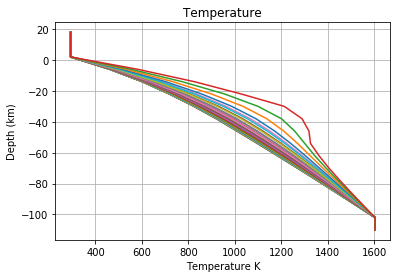

In [26]:
MyTemperatureField=(Model.temperature.data[:] * GEO.Dimensionalize(1.0, u.degK)).magnitude 

TemperatureData=np.asarray(MyTemperatureField)
TemperatureDataShaped=TemperatureData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(TemperatureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(TemperatureDataShaped[:, resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Temperature K')
plt.ylabel('Depth (km)')
plt.title('Temperature')
plt.show()

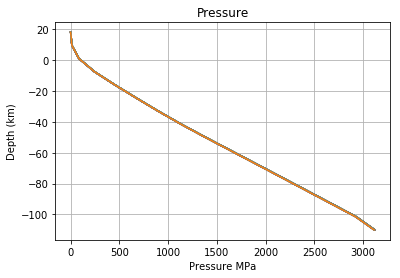

In [27]:
MyPressureField=(Model.pressureField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

PressureData=np.asarray(MyPressureField)
PressureDataShaped=PressureData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.
plt.plot(PressureDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(PressureDataShaped[:,resolution[2]/2], np.linspace(Model.bottom,Model.top,resolution[1]))

## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
#plt.xscale('log')
plt.xlabel('Pressure MPa')
plt.ylabel('Depth (km)')
plt.title('Pressure')
plt.show()



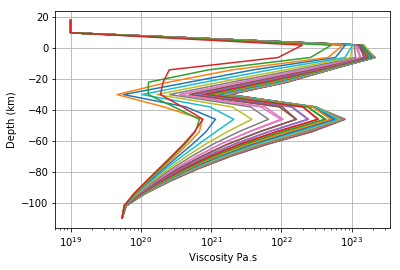

In [28]:
MyViscosityField=(Model.projViscosityField.data[:] * GEO.Dimensionalize(1.0, u.pascal * u.second)).magnitude 

ViscosityData=np.asarray(MyViscosityField)
ViscosityDataShaped=ViscosityData.reshape(resolution[1]+1,resolution[0]+1,resolution[2]+1)

#Two profiles located at the left walls and the middle.
plt.plot(ViscosityDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]+1))
plt.plot(ViscosityDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]+1))



## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xscale('log')
plt.xlabel('Viscosity Pa.s')
plt.ylabel('Depth (km)')
## plt.title('Viscosity')
plt.show()



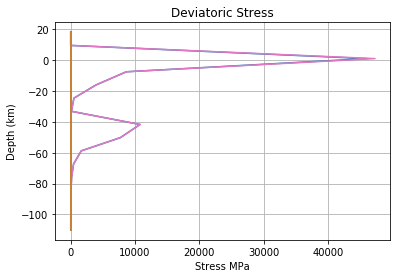

In [29]:
MyStressField=(Model.projStressField.data[:] * GEO.Dimensionalize(1.0, u.megapascal)).magnitude 

StressData=np.asarray(MyStressField)
StressDataShaped=StressData.reshape(resolution[1],resolution[0],resolution[2])

#Two profiles located at the left walls and the middle.

plt.plot(StressDataShaped[:,0], np.linspace(Model.bottom,Model.top,resolution[1]))
plt.plot(StressDataShaped[:,resolution[0]/2], np.linspace(Model.bottom,Model.top,resolution[1]))


## plt.yticks([-700,-300,-150,-40,0,68])
## plt.xticks([20, 550.0, 1350])
plt.grid()
plt.xlabel('Stress MPa')
plt.ylabel('Depth (km)')
plt.title('Deviatoric Stress')
plt.show()

In [ ]:
Model.run_for(20.0 * u.megayears, checkpoint_interval=0.01 * u.megayears)